# LASER Modeling with DataFrames

## Single Node

### SQLite

Ran SQLite model: pop=1e6. 1 node. EULA at 25yrs. SEIRS. Ran in terminal: 412s.

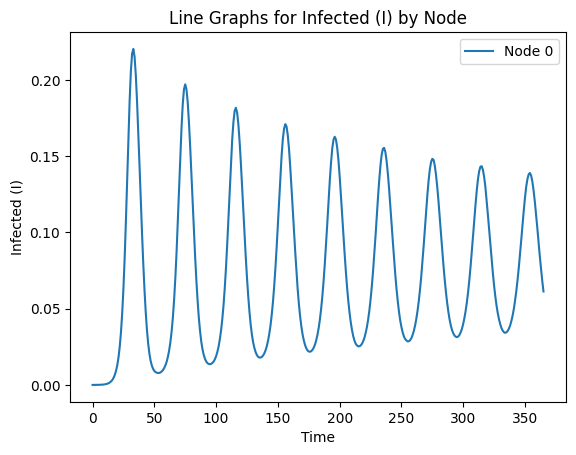

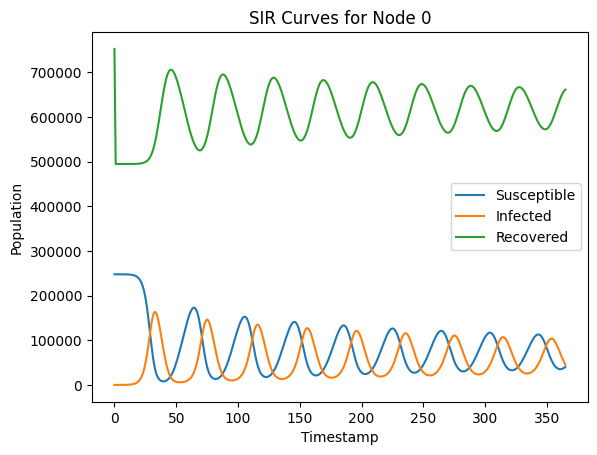

In [ ]:
from viz import plot_spatial
filepath = "sim_output_sql_1node_1year_eulaat25.csv"
plot_spatial.load_and_plot(filepath)
from viz import plot_sir_for_node as myplot
myplot.plot_sir_curves(filepath, 0)

### Numpy

143 seconds

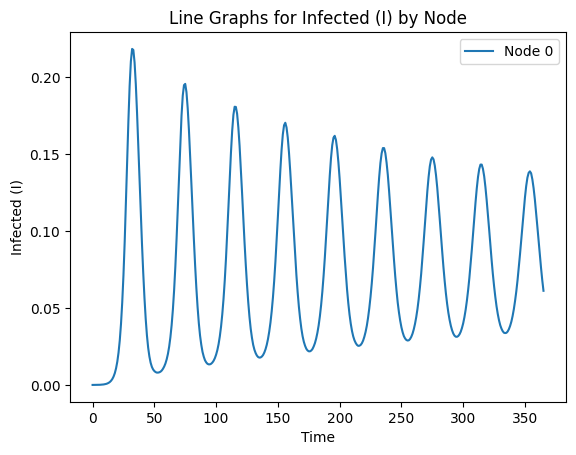

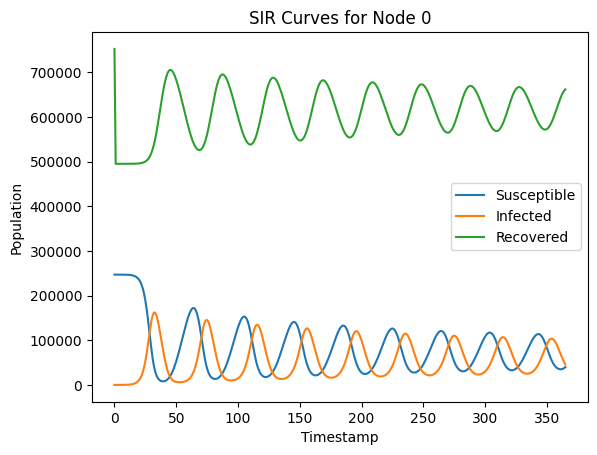

In [ ]:
from viz import plot_spatial
filepath = "sim_output_numpy_1node_1year_eulaat25.csv"
plot_spatial.load_and_plot(filepath)
from viz import plot_sir_for_node as myplot
myplot.plot_sir_curves(filepath, 0)

### C-accelerated Numpy

2.4seconds (we're clearly not using the EULAs in our counting properly here yet.)

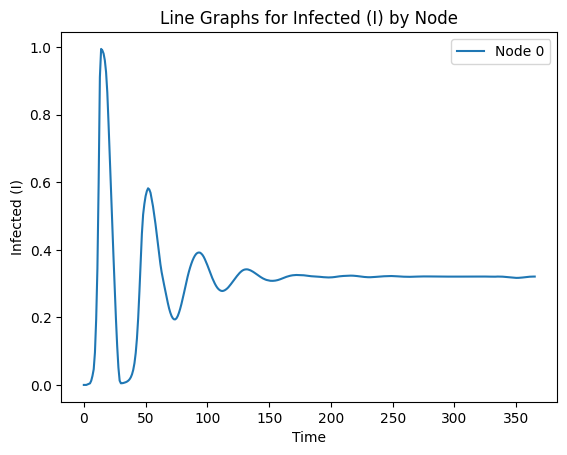

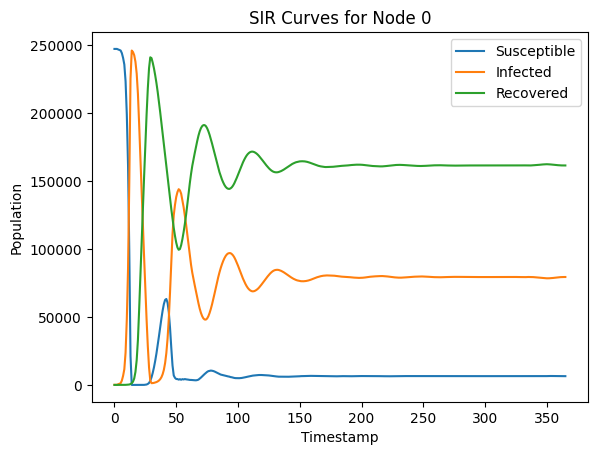

In [ ]:
from viz import plot_spatial
filepath = "sim_output_numpyc_1node_1year_eulaat25.csv"
plot_spatial.load_and_plot(filepath)
from viz import plot_sir_for_node as myplot
myplot.plot_sir_curves(filepath, 0)

## 25 nodes

### SQL

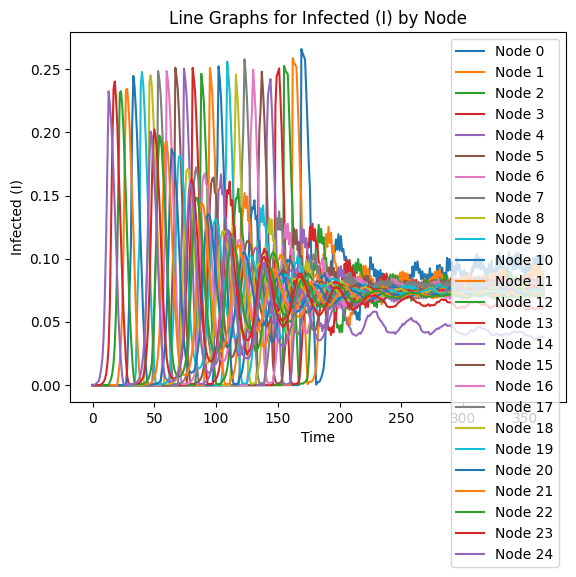

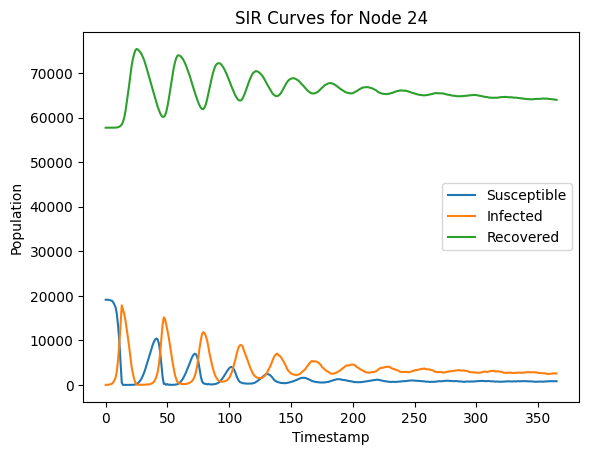

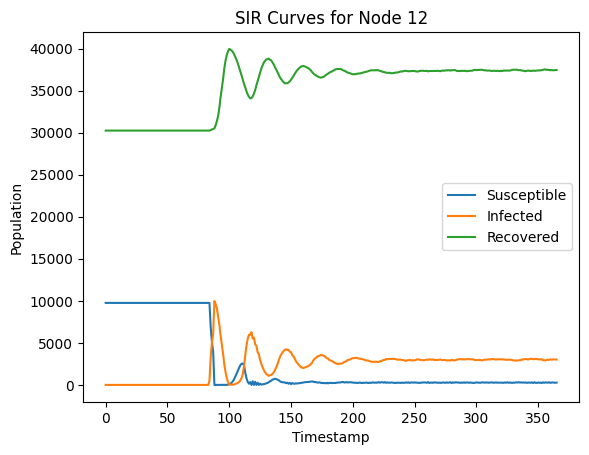

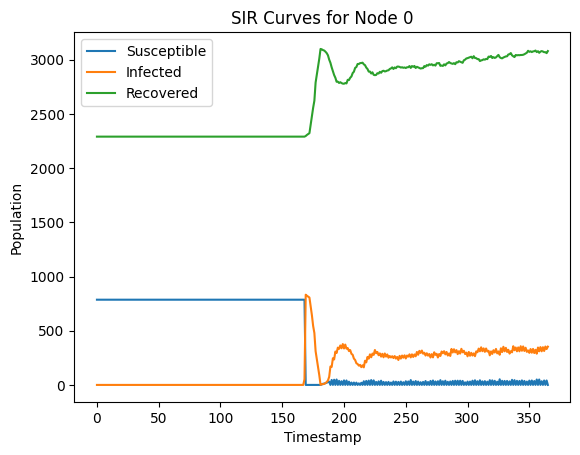

In [ ]:
from viz import plot_spatial
filepath = "sim_output_sql_25nodes_1year_eulaat25_b.csv"
plot_spatial.load_and_plot(filepath)
from viz import plot_sir_for_node as myplot
myplot.plot_sir_curves(filepath, 24)
myplot.plot_sir_curves(filepath, 12)
myplot.plot_sir_curves(filepath, 0)

### Numpy

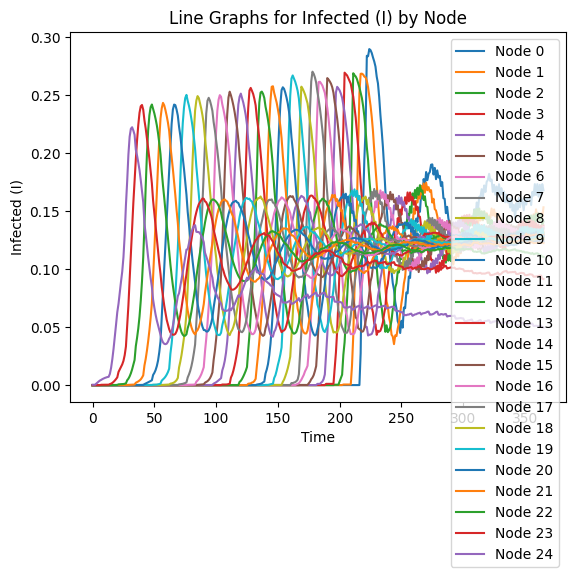

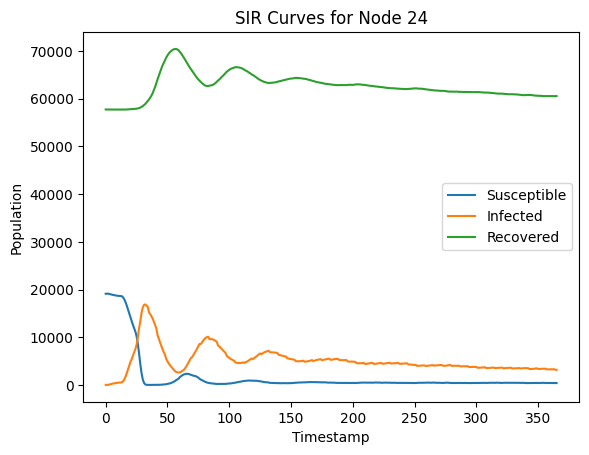

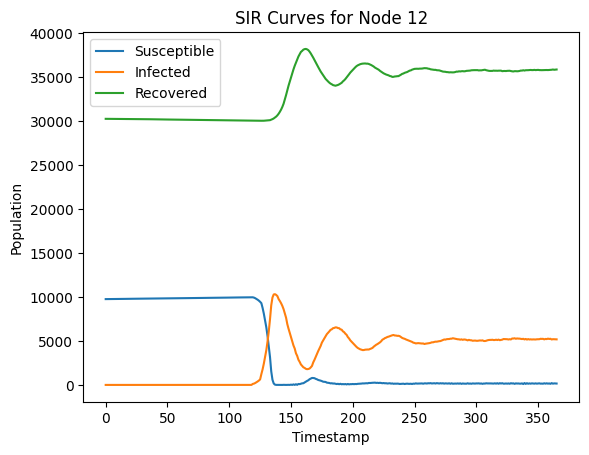

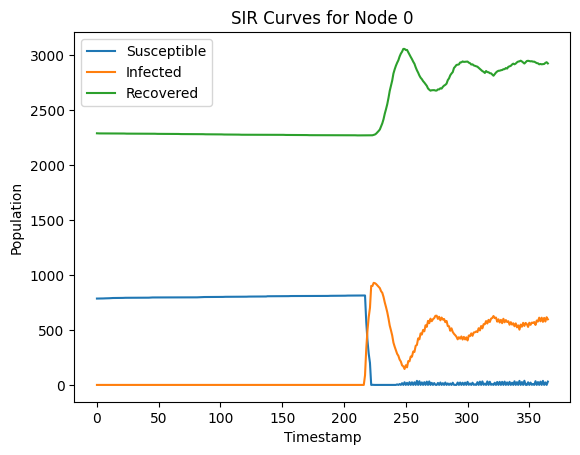

In [ ]:
from viz import plot_spatial
filepath = "sim_output_numpy_25nodes_1year_eulaat25b.csv"
plot_spatial.load_and_plot(filepath)
from viz import plot_sir_for_node as myplot
myplot.plot_sir_curves(filepath, 24)
myplot.plot_sir_curves(filepath, 12)
myplot.plot_sir_curves(filepath, 0)

### C-accelerated Numpy

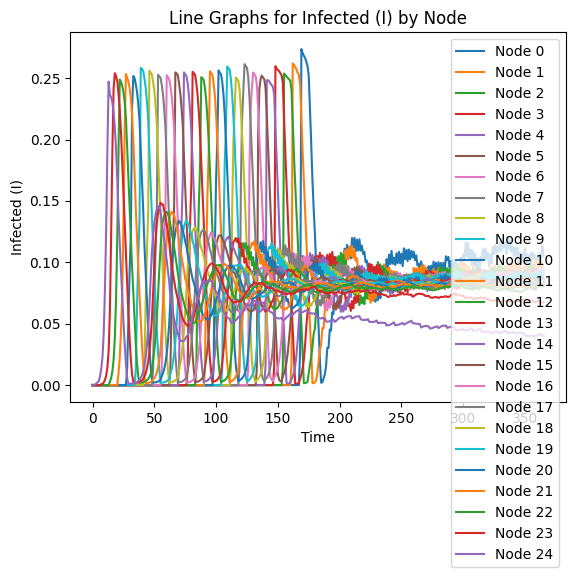

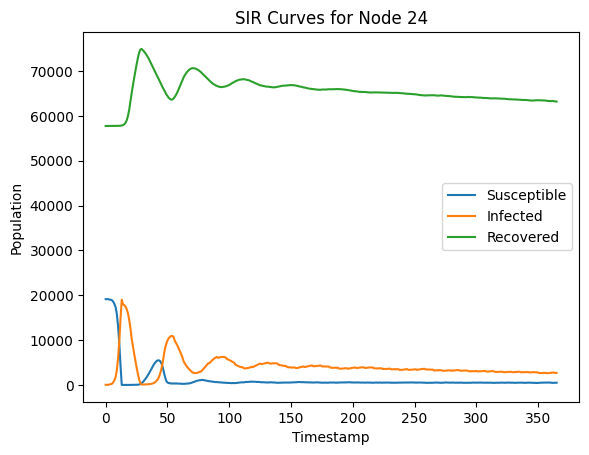

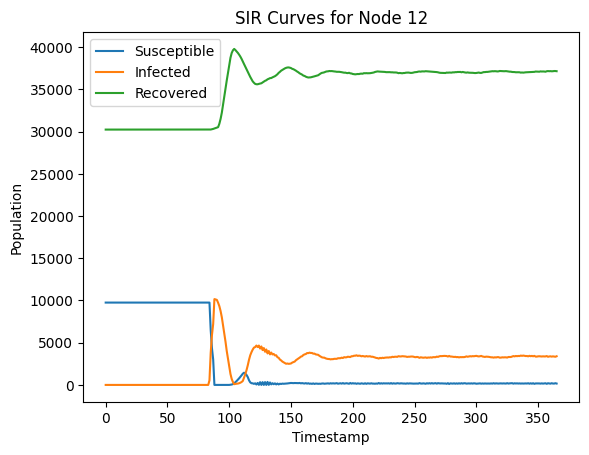

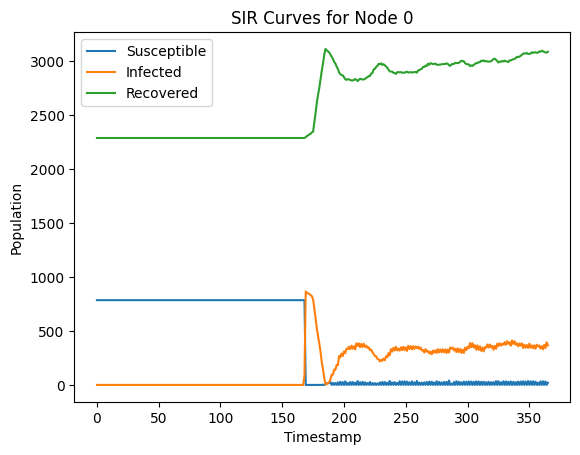

In [ ]:
from viz import plot_spatial
filepath = "sim_output_numpyc_25nodes_1year_eulaat25b.csv"
plot_spatial.load_and_plot(filepath)
from viz import plot_sir_for_node as myplot
myplot.plot_sir_curves(filepath, 24)
myplot.plot_sir_curves(filepath, 12)
myplot.plot_sir_curves(filepath, 0)

## Commentary

The outputs ought to be identical-ish for the 3 different model types, but there isn't a complete convergence of what features are on/off (e.g., births and natural deaths) let alone infection and immune duration. We'll get there.

## EULA

EULA stands for Epidemiologically Useless Light Agents. This can be 90% of the total population. The idea is to stop actively modeling agents who are permanently immune without completely losing track of them. Even using technology which makes modeling faster, we think we might be able to get a 10x speedup by moving these agents out of the actively modeled population. And depending on the EULA approach, we may also be able to save memory. We've explored several options:

1) Default/Nothing. Model them and work around them. This is the default.

2) Delete them. (And remember the true population for reporting.) This obviously isn't a long-term solution if you are using transmission math which factors is the total human population. But as a quick test it confirms the speedup benefits across a variety of modeling technology choices (from SQL to Numpy to C).

3) Downsample to N (+mcw). We deleted them but added a row to each node representing the EULA population, and we added a property "mcw" -- monte carlo weight -- to each agent. So all the modeled agents have a weight of 1 and the EULA pop has a weight of the total number of the number of EULA agents. This has the benefit of keeping the whole population in one place and just one way of doing things. But the eula agents need values for all the other attributes. Some are easy like immunity and immunity_timer, but others like "age" need to have synthetic values. We also need to make sure all our other code uses logic that doesn't actually operate on the EULA agents. It can be tricky to always be writing model code and remember that there are "dummy agents" that need to be ignored. Also, we were initially doing fertility by counting the number of women of childbearing age. That become impossible with this level of downsampling, so we switched to fertility by crude birth rate. Which is perfectly reasonable but it might be nice not to rule out other, more detailed ways of doing birth dates. Also, we had started doing mortality by giving everyone a pre-calculated lifespan, but with downsampled EULA agents we had to switch to a statistical way of doing natural mortality. Which is surprisingly expensive.  

4) Downsample by yearly age bin (+mcw). An improvement on the above was to downsample less aggressively -- have an "mcw agent" for each yearly age bin (for each node). Using a EULA threshold age of 5, that's about 85 rows. With 1,000 nodes -- not yet tried personally -- that's 85,000 rows. Not nothing. This approach lets us do age-specific statistical mortality and also count the number of women of child-bearing age. But we're starting to get the worst of both worlds: more complexity for the modeler and some cost in the total number of rows.

5) Separate. At this point we switched to the idea of putting the EULA pop into its own table/dataframe/set of vectors. We actually stopped downsampling at all. So we're using the same amount of RAM as we started, but we get almost all the perf benefits of deletion and the coding simplicity of not having to remember that there are "dummy agents in our table". The downside is we now have "two ways of doing things". The modeler has to remember that when counting how many people are in a node, they have to go to two places. Is 2 just one more than 1, or twice as many as 1? :) If there are 2 places, is there a third place? I will also add a note here that so far all natural mortality is from R->D. But by retaining all the agents with no downsampling, we can go back to precalculated lifespans and kill people off the same way from both tables. BUt we can not really go back to population recycling because the vast majority of deaths are coming from the EULA table/arrays and all the births are going into the regular table/arrays.

6) Pre-process and Separate. Since Separation seemed to be a good idea, net net, it made sense to pre-process the population and do the population split before running the model. This adds some complexity in the sense that running the model becomes a multi-step activity, but longstanding tools like "make" can handle this easily. But maybe that's adding a new dependency and tool for some users? Should these intermediate files be retained? Does that feel like clutter to the end user?

7) Database. We added a pre-processing step of converting the eula csv to a sqlite db. The code then does the population counting and mortality updating queries in a more RAM-parsimonious way, potentially. This turns out not to be performant for the numpy and C-accelerated numpy models, compared to simply storing the counts in a dictionary. One could use a dict to cache the initial query and maybe get the best of both worlds.

Componentization. Finally we will note that we moved the two surviving eula implementations into standalone submodules. These are very small dedicated "scripts" that have the same name and same function signature, but live in separate directories. This lets the user do "from sql_model import eula" or "from numpy_model import eula" with no other changes to code or settings. Not sure if that's preferable to changing config parameters.

## Next Steps

- Explore EULA population as SQLite db on disk as reusable component across all models.

- Births and deaths across all models

- Componentization across models.

- Test & consistency across models.

- Decoupled, single-solution 2D viz.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=82cd4c70-3e2b-4394-af1f-762535ee8a0d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>